# Imports

In [1]:
import torch
import numpy as np

from DKL.data.dataset import generate_2d_data
import DKL.data.transformations as f
from DKL.training.main_trainer import train_joint_model
from DKL.training.extra_trainer import train_naive_gp
from DKL.training.extra_trainer import train_ideal_gp
from DKL.utils.display import test_new_realization, plotting

# Seed Definition

In [2]:
torch.manual_seed(43)
np.random.seed(43)

# Device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Data Generation

In [4]:
## Hyperparameters for synthetic guassian process generation

N_training = 1200 
test_grid_size = 16
noise_level = 0.05
scale = 5.0
function = f.transform_sin
lengthscale = 12.0

# Generate multiple data realizations on random points
common_data, realization = generate_2d_data(function, lengthscale= lengthscale,
                                             n_train_points= N_training , 
                                             test_grid_size=test_grid_size, 
                                             scale=scale, noise_level=noise_level, 
                                             device=device)

  - 1200 points aléatoires d'entraînement par realisation
  - Maillage de visualisation 16x16 (256 points) pour le test
Stats Y (train) min=-1.8599, max=2.6015, mean=0.5502, std=0.8277
Stats Y (test grid) min=-1.5421, max=1.9911, mean=0.5094, std=0.8234
Génération de données terminée.


In [5]:
## Hyperparameters for Normalizing Flow and Gaussian process Learning

num_epochs = 21
flow_learning_rate = 0.01 # Separate learning rate for flow
gp_learning_rate = 0.01 # Separate learning rate for GP/Likelihood (can be different)
num_flow_blocks = 12 # Number of blocks in the RealNVP flow model
freeze_gp_params = False # Set to True to freeze GP/Likelihood params during joint training
nouvel_entrainement = True # Set to True to start fresh training, False to resume from checkpoint
if nouvel_entrainement:
    %rm -rf ../models/*

# Train the joint model with separate learning rates
trained_flow, trained_gp, trained_likelihood, loss_history  = train_joint_model(common_data,
                                                                                realization,
                                                                                num_epochs=num_epochs, 
                                                                                flow_lr=flow_learning_rate, 
                                                                                gp_lr=gp_learning_rate,
                                                                                num_flow_blocks=num_flow_blocks,
                                                                                patience=50, delta = 0.001, 
                                                                                no_learn_lengthscale=freeze_gp_params)


RealNVP model created with 12 affine blocks.
MLP output layers initialized to zeros for near-identity transform.
Aucun checkpoint trouvé. Début de l'entraînement à zéro.

Début de l'entraînement...
Entraînement terminé.
Chargement du meilleur modèle joint depuis /Users/solal/Desktop/DKL/models/learned_gp_checkpoint.pth pour le retour final...


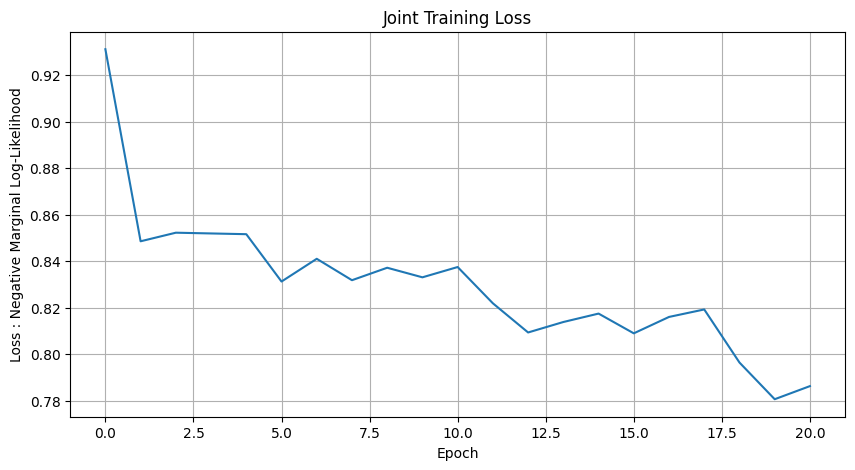

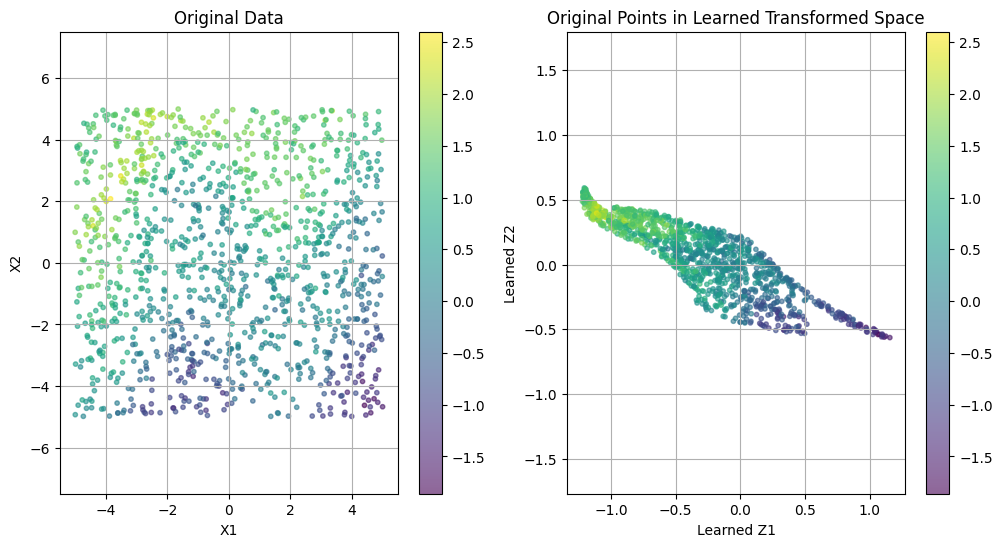

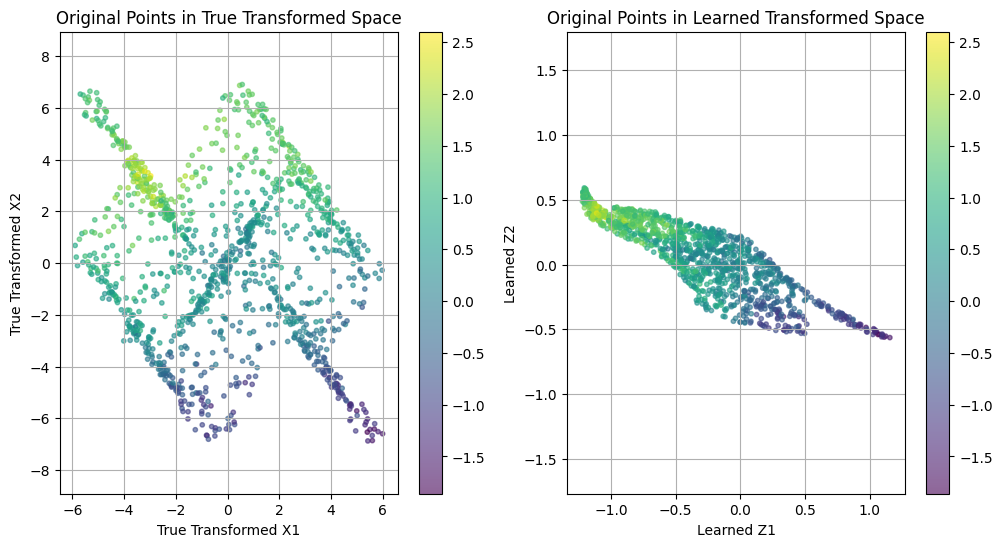


Generating visualization grid for learned transformation...


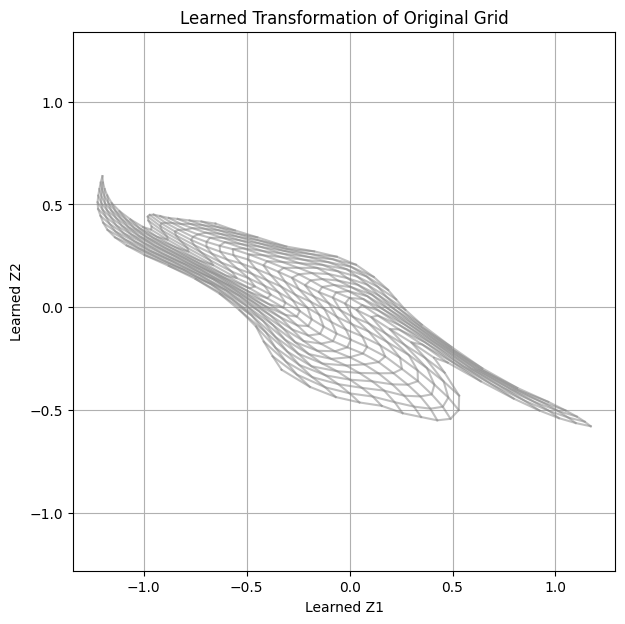

In [6]:
plotting(trained_flow,trained_gp,trained_likelihood,
         common_data, realization,
        function,loss_history,scale
        )

## Naive and Ideal Gaussian Processes

In [7]:
naive_gp_model, naive_likelihood = train_naive_gp(common_data, realization,
                                                num_epochs=100,lr=0.1, 
                                                checkpoint_name='naive_gp_checkpoint.pth')


Aucun checkpoint Naive GP trouvé. Début de l'entraînement.
Entraînement du GP Naif sur les données originales pour 100 époques (début 0)...
  Naive GP Époque 10/100: Perte 0.5617, Longueur de corrélation: [[1.2909819]], Échelle de sortie: 0.3265, Bruit: 0.3117
  Meilleure perte détectée et époque éligible.
  Naive GP Époque 20/100: Perte 0.2138, Longueur de corrélation: [[1.9128639]], Échelle de sortie: 0.2091, Bruit: 0.1252
  Meilleure perte détectée et époque éligible.
  Naive GP Époque 30/100: Perte 0.0219, Longueur de corrélation: [[2.2517252]], Échelle de sortie: 0.2916, Bruit: 0.0537
  Meilleure perte détectée et époque éligible.
Early Stopping activé à l'époque 47! Aucune amélioration depuis 10 époques.
Entraînement Naive GP terminé.
Chargement du meilleur modèle Naive GP depuis /Users/solal/Desktop/DKL/models/naive_gp_checkpoint.pth pour le retour final...


In [8]:
ideal_gp_model, ideal_likelihood =  train_ideal_gp(common_data, realization,
                                                   function, lengthscale = lengthscale,
                                                    num_epochs=100,lr=0.1,
                                                    checkpoint_name='ideal_gp_checkpoint.pth')

Aucun checkpoint GP transformé trouvé. Début de l'entraînement.
Entraînement du GP transformé pour 100 époques (début 0)...
  GP transformé Époque 10/100: Perte 0.5557, Longueur de corrélation: [[1.2946991]], Échelle de sortie: 0.3245, Bruit: 0.3119
  Meilleure perte détectée et époque éligible.
  GP transformé Époque 20/100: Perte 0.1841, Longueur de corrélation: [[1.9765587]], Échelle de sortie: 0.1831, Bruit: 0.1255
  Meilleure perte détectée et époque éligible.
  GP transformé Époque 30/100: Perte -0.0111, Longueur de corrélation: [[2.5814083]], Échelle de sortie: 0.1801, Bruit: 0.0534
  Meilleure perte détectée et époque éligible.
Early Stopping activé à l'époque 45! Aucune amélioration depuis 10 époques.
Entraînement GP transformé terminé.
Chargement du meilleur modèle Ideal GP depuis /Users/solal/Desktop/DKL/models/ideal_gp_checkpoint.pth pour le retour final...


## Performances comparisons


--- Testing with Existing Test Grid ---
Using the initial test grid data from generation...
Predicting and Sampling from Learned GP on test grid...


Prédictions GP: 100%|██████████| 2/2 [00:00<00:00, 17.37it/s]


Predicting and Sampling from Guessed GP on test grid...


Prédictions GP: 100%|██████████| 2/2 [00:00<00:00,  9.41it/s]


Predicting and Sampling from True Transformed GP on test grid...


Prédictions GP: 100%|██████████| 2/2 [00:00<00:00, 15.17it/s]



Calculating MSE on Initial Test Grid Data...
MSE (Learned Non-Stationary GP) vs True Test Grid (Rzn 0): 0.052690
MSE (Best Stationary GP in Original Space) vs True Test Grid (Rzn 0): 0.007743
MSE (Stationary GP on TRUE Transformed Space) vs True Test Grid (Rzn 0): 0.051682

 Plotting Predictions Comparison on Initial Test Grid...


<Figure size 1600x1200 with 0 Axes>

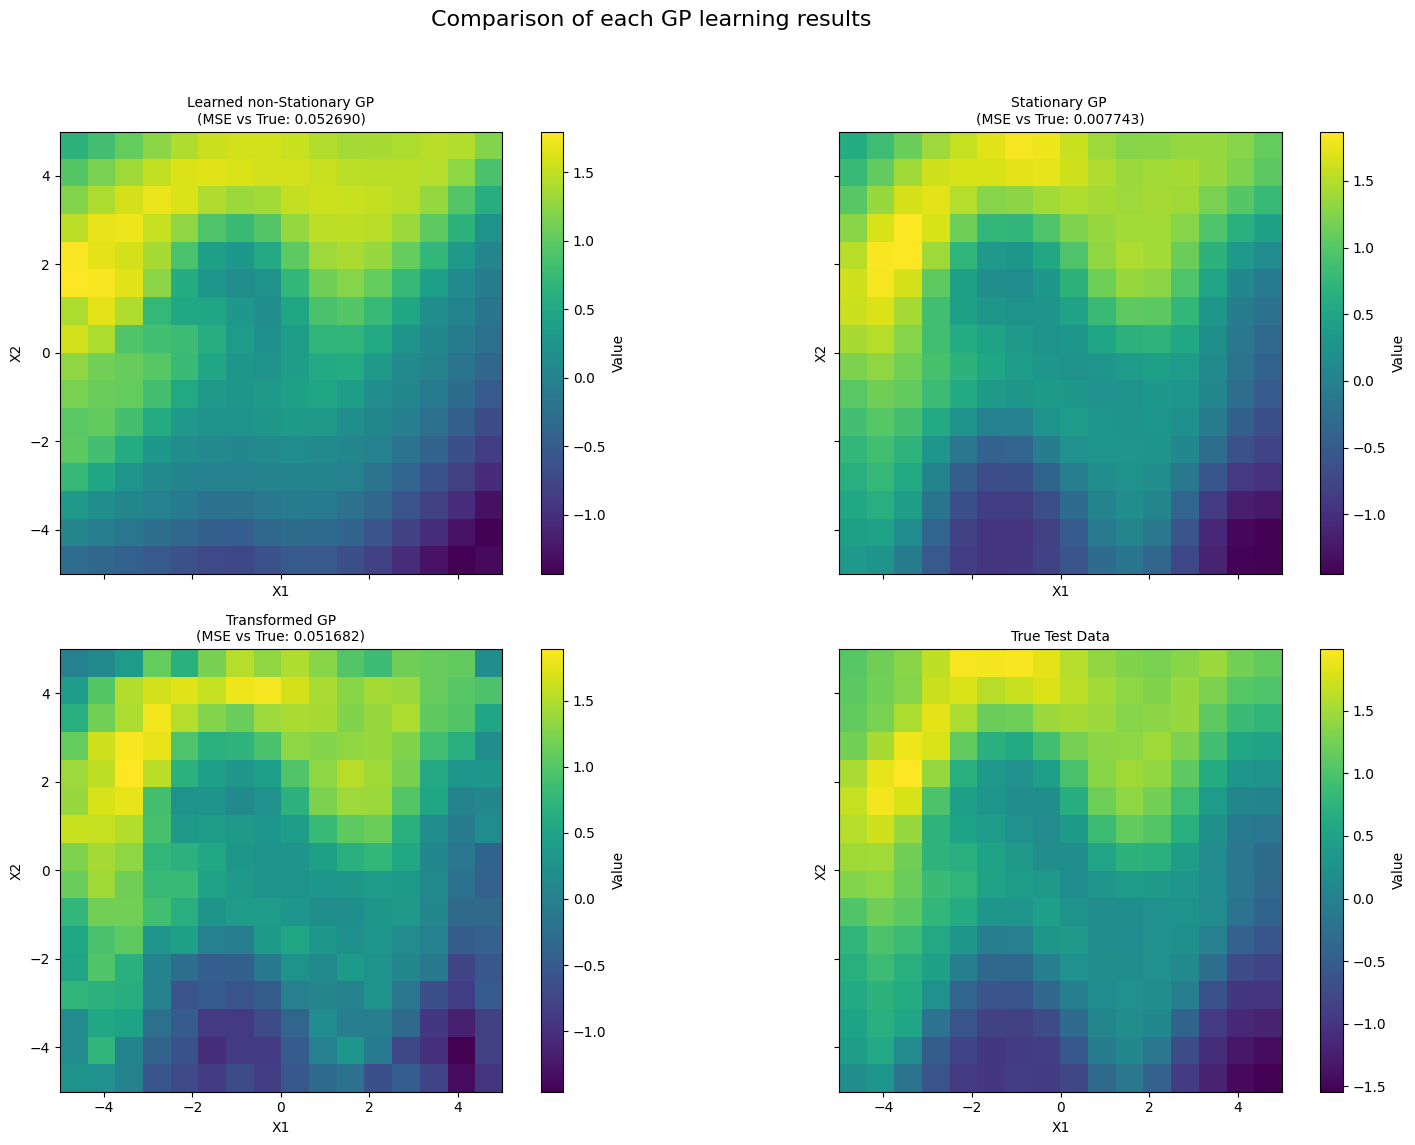


 Plotting Variances Comparison on Initial Test Grid...


<Figure size 1600x1200 with 0 Axes>

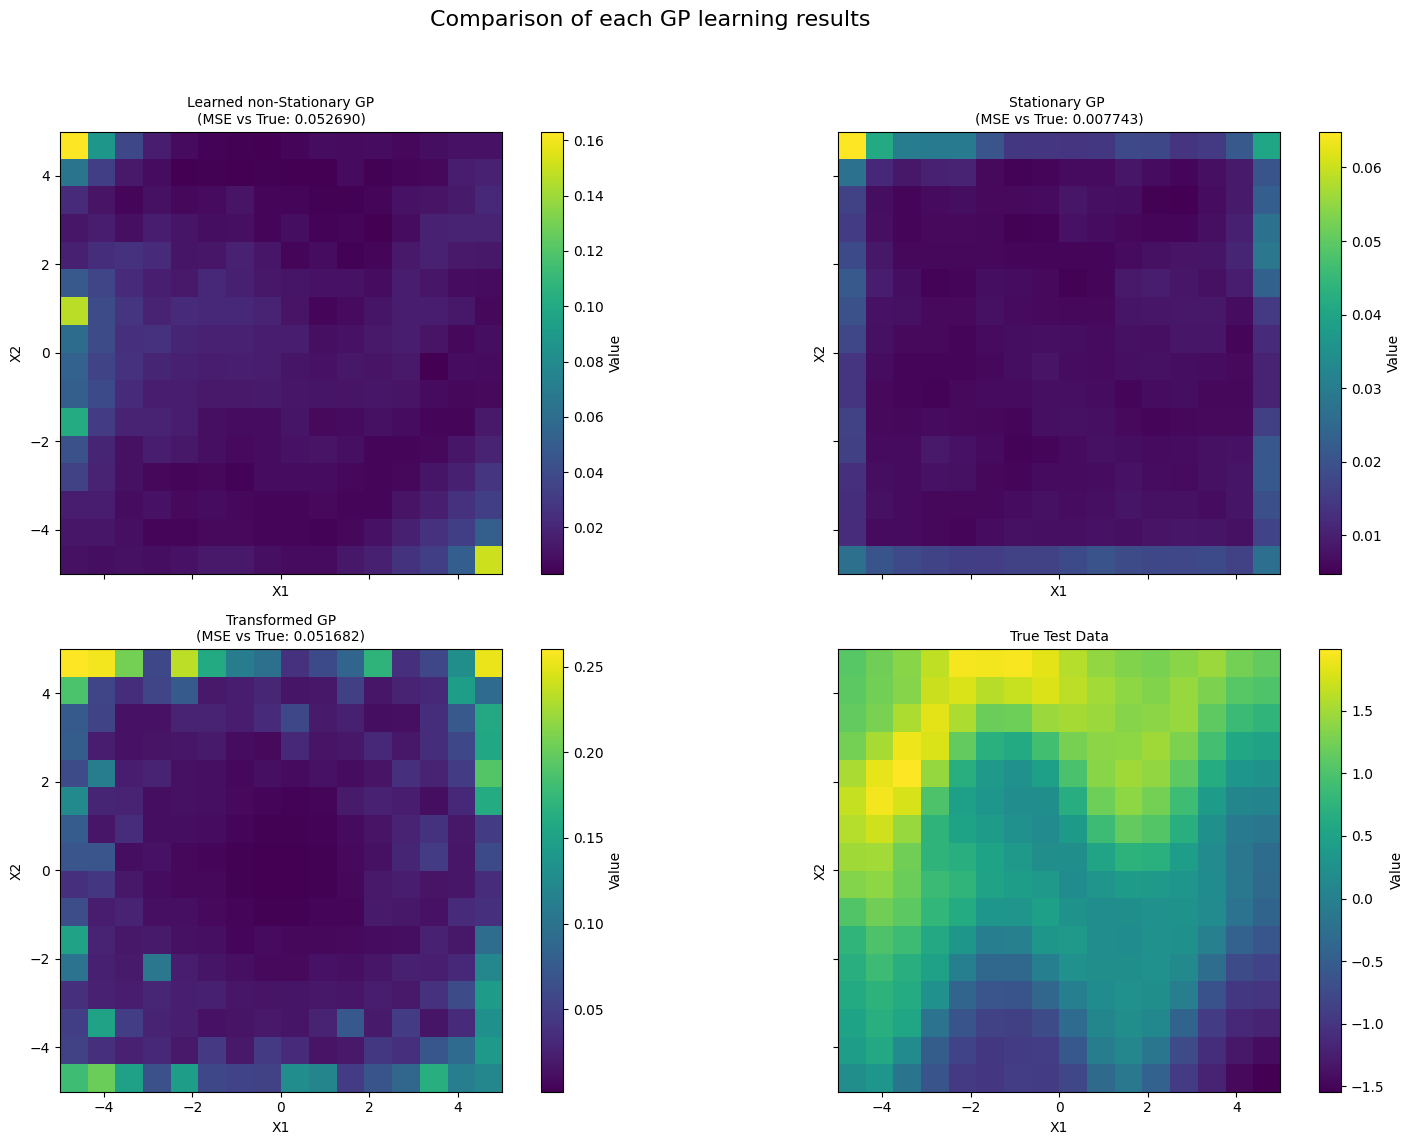


 Plotting CRPS Comparison on Initial Test Grid...


<Figure size 1600x1200 with 0 Axes>

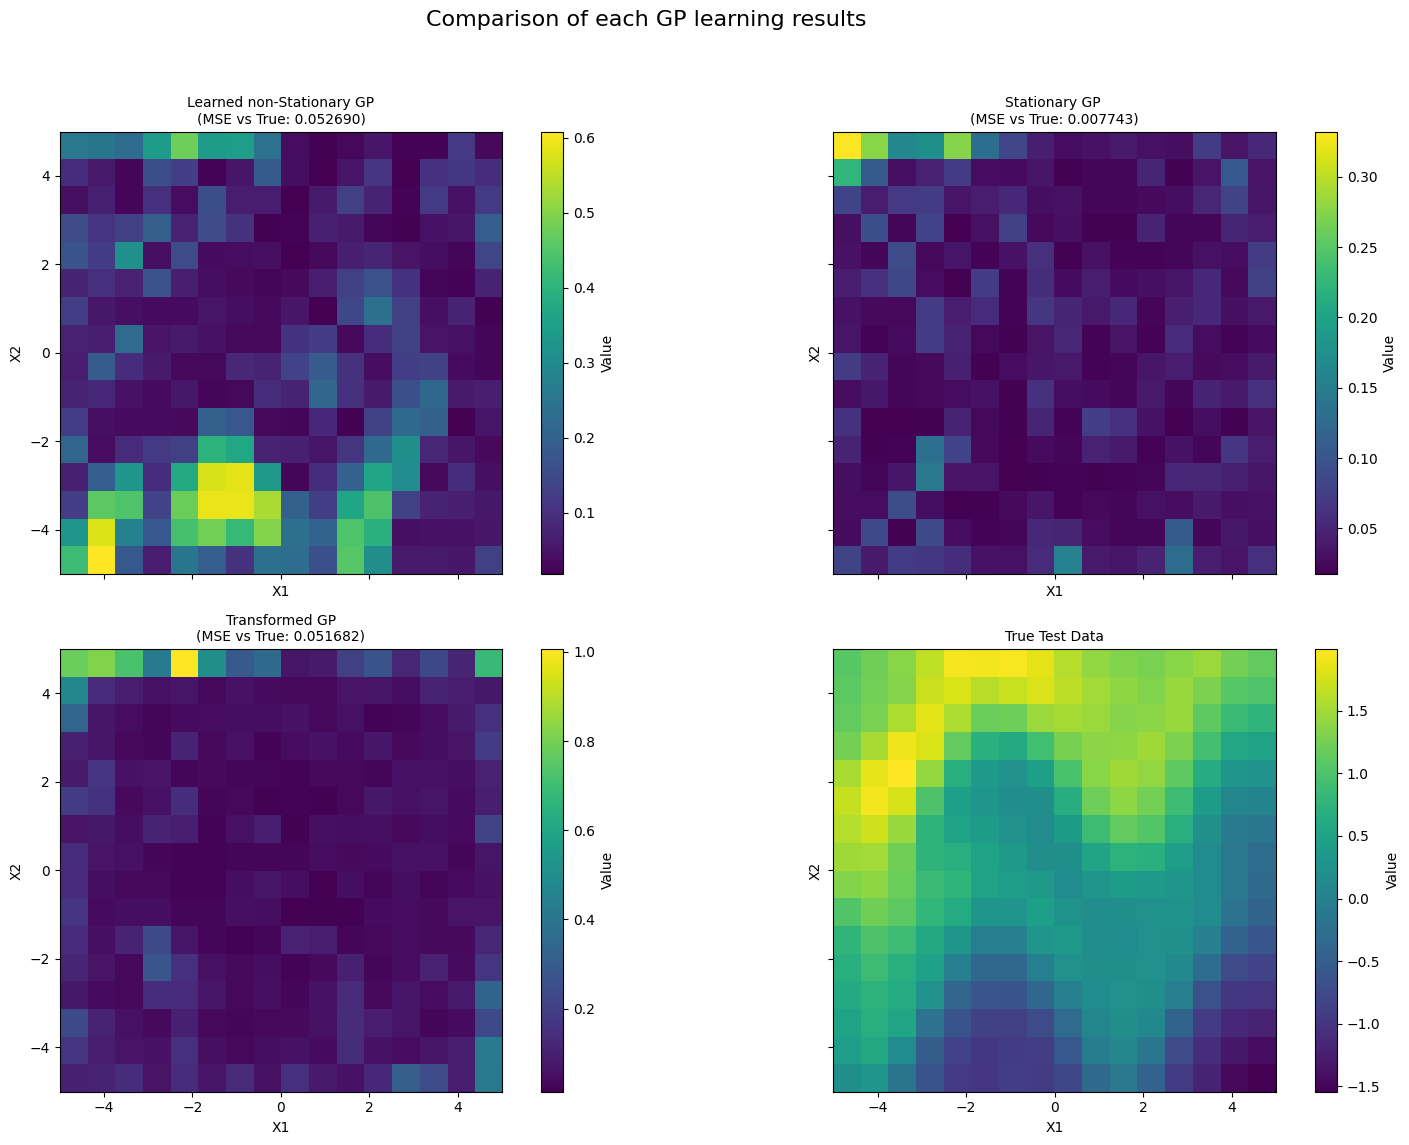

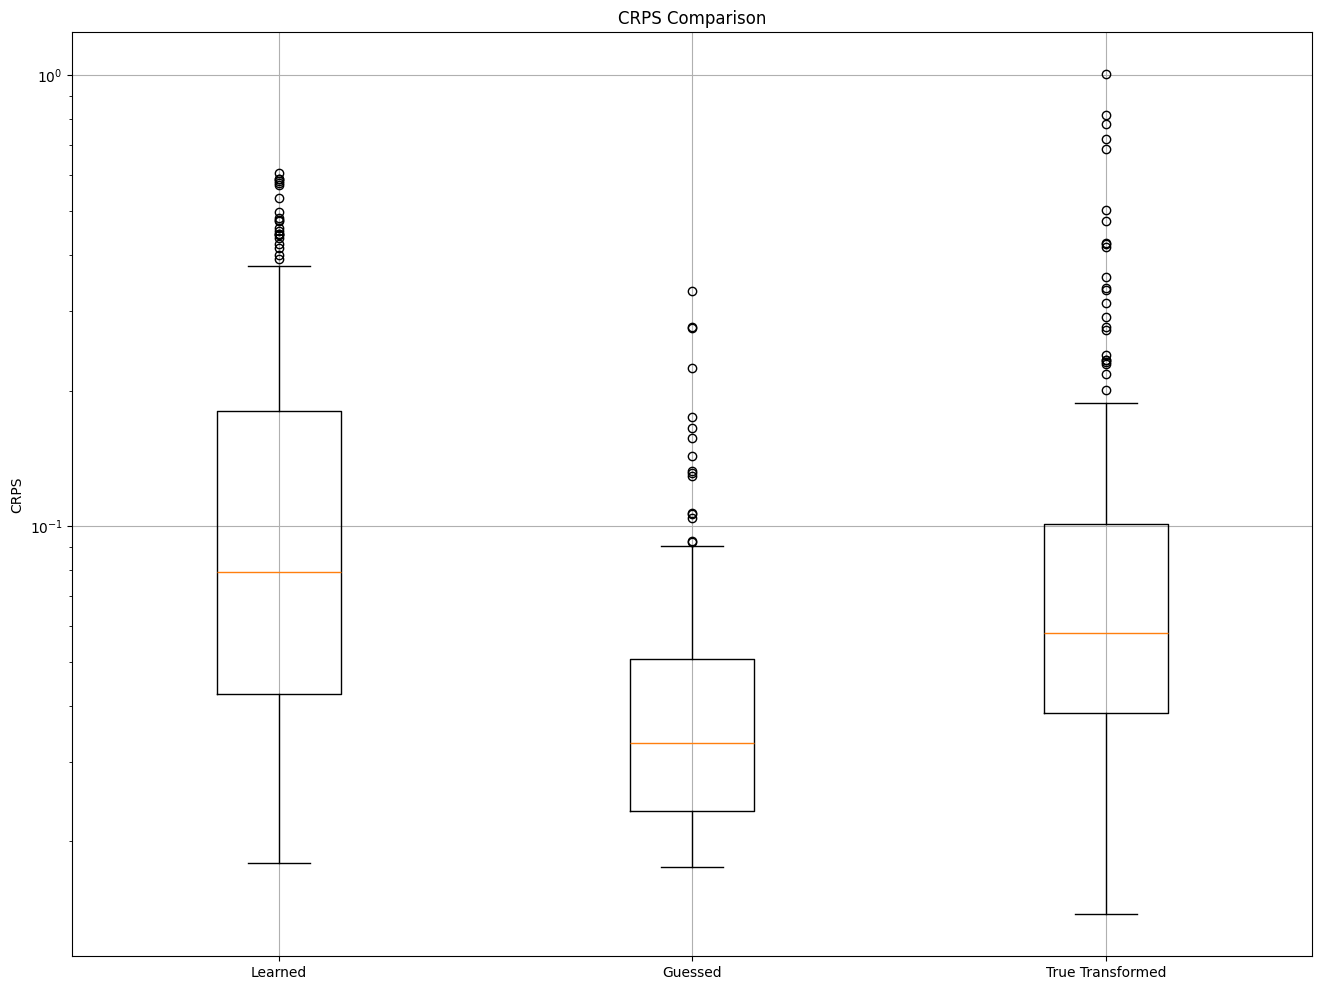

Evaluation finished.


In [ ]:
test_new_realization(trained_flow, trained_gp,
                     trained_likelihood, naive_gp_model,
                     naive_likelihood, ideal_gp_model, ideal_likelihood,
                     common_data, realization, scale)